In [10]:
from urllib.request import urlretrieve
url = "https://github.com/hankhuang1998/test/raw/main/train.csv"
urlretrieve(url, "train.csv")

url = "https://github.com/hankhuang1998/test/raw/main/test.csv"
urlretrieve(url, "test.csv")

('test.csv', <http.client.HTTPMessage at 0x7f98a811ffd0>)

In [11]:
import pandas as pd
train_df = pd.read_csv("train.csv", encoding="utf-8")
test_df = pd.read_csv("test.csv", encoding="utf-8")

In [12]:
datas = pd.concat([train_df, test_df], axis=0, ignore_index=True)
datas

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [13]:
s = datas.isna().sum()
# Series[True/False]
s[s > 0].sort_values(ascending=False)

Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
dtype: int64

In [14]:
datas = datas.drop(["PassengerId", "Survived"], axis=1)

In [15]:
# 數值類型補中位數
med = datas.median().drop("Pclass")
datas = datas.fillna(med)

In [16]:
# 類別類型捕最常出現
most = datas["Embarked"].value_counts().idxmax()
datas["Embarked"] = datas["Embarked"].fillna(most)
s[s > 0].sort_values(ascending=False)
s[s > 0].sort_values(ascending=False)

Cabin       1014
Survived     418
Age          263
Embarked       2
Fare           1
dtype: int64

In [17]:
def cabin(s):
  if pd.isna(s):
    return None
  else:
    return s[0]
datas["Cabin"] = datas["Cabin"].apply(cabin)

In [18]:
def name(s):
    mid = s.split(",")[-1].split(".")[0]
    mid = mid.strip()
    return mid
count = datas["Name"].apply(name).value_counts()
reserved = count[:4].index
def name2(s):
    mid = s.split(",")[-1].split(".")[0]
    mid = mid.strip()
    if mid in reserved:
        return mid
    else:
        return None
datas["Name"] = datas["Name"].apply(name2)

In [19]:
dic = datas["Ticket"].value_counts()
def ticket(t):
  return dic[t]
datas["Ticket"] = datas["Ticket"].apply(ticket)

In [20]:
datas = pd.get_dummies(datas)
datas = pd.get_dummies(datas, columns=["Pclass"])
datas

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [21]:
# 統計上做的事情要有意義 、 利用已存在的欄位做出新的欄位資料
datas["Family"] = datas["SibSp"] + datas["Parch"]
datas

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [22]:
y = train_df["Survived"]
# .iloc: [1st row, 2nd rows....]
x = datas.iloc[:len(train_df)]
predict = datas.iloc[len(train_df):]

In [23]:
# 隨機森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
params = {
    "n_estimators":range(50, 100, 2),
    "max_depth":range(5, 11)
}
grid = GridSearchCV(clf, params, cv=10, n_jobs=-1, scoring="neg_log_loss")
grid.fit(x,y)
print(grid.best_score_)
print(grid.best_params_)

-0.39752390083123834
{'max_depth': 6, 'n_estimators': 74}


In [24]:
# 交叉驗證  accuracy_score這邊不能用
import numpy as np
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(n_estimators=53, max_depth=7)
scores = cross_val_score(clf, x, y, cv=10, n_jobs=-1)
print(scores)
print(np.average(scores))
clf = RandomForestClassifier(n_estimators=31, max_depth=6)
scores = cross_val_score(clf, x, y, cv=10, n_jobs=-1, scoring="neg_log_loss")
print(scores)
print(np.average(scores))

[0.82222222 0.85393258 0.74157303 0.88764045 0.87640449 0.84269663
 0.83146067 0.7752809  0.86516854 0.82022472]
0.8316604244694131
[-0.46986934 -0.38112941 -0.60290812 -0.35460332 -0.36367749 -0.39172399
 -0.39763388 -0.42026952 -0.32009887 -0.36593289]
-0.4067846837833664


In [26]:
clf = RandomForestClassifier(n_estimators=31, max_depth=6)
clf.fit(x,y)
pre = clf.predict(predict)
ans = pd.DataFrame({
    "Passengerid":test_df["PassengerId"],
    "Survived":pre
})
ans.to_csv("rf.csv", encoding="utf-8", index=False)

In [27]:
import pandas as pd
pd.DataFrame(clf.feature_importances_, 
       columns=["Importance"],
       index=datas.columns).sort_values(by="Importance", ascending=False)

,Importance
Sex_male,0.160229
Sex_female,0.153673
Name_Mr,0.128189
Fare,0.086521
Pclass_3,0.063874
Age,0.061681
Family,0.057079
Name_Miss,0.047876
Ticket,0.045283
Pclass_1,0.029910


[Text(390.6, 665.91, 'Sex_male <= 0.5\ngini = 0.464\nsamples = 568\nvalue = [565, 326]\nclass = Dead'),
 Text(195.3, 475.65, 'SibSp <= 2.5\ngini = 0.41\nsamples = 200\nvalue = [90, 223]\nclass = Alive'),
 Text(97.65, 285.39, 'Fare <= 21.717\ngini = 0.372\nsamples = 185\nvalue = [72, 219]\nclass = Alive'),
 Text(48.825, 95.13, '\n  (...)  \n'),
 Text(146.47500000000002, 95.13, '\n  (...)  \n'),
 Text(292.95000000000005, 285.39, 'Age <= 29.0\ngini = 0.298\nsamples = 15\nvalue = [18, 4]\nclass = Dead'),
 Text(244.125, 95.13, '\n  (...)  \n'),
 Text(341.77500000000003, 95.13, '\n  (...)  \n'),
 Text(585.9000000000001, 475.65, 'Fare <= 18.375\ngini = 0.293\nsamples = 368\nvalue = [475, 103]\nclass = Dead'),
 Text(488.25, 285.39, 'Cabin_D <= 0.5\ngini = 0.207\nsamples = 231\nvalue = [317, 42]\nclass = Dead'),
 Text(439.425, 95.13, '\n  (...)  \n'),
 Text(537.075, 95.13, '\n  (...)  \n'),
 Text(683.5500000000001, 285.39, 'Cabin_E <= 0.5\ngini = 0.402\nsamples = 137\nvalue = [158, 61]\nclass =

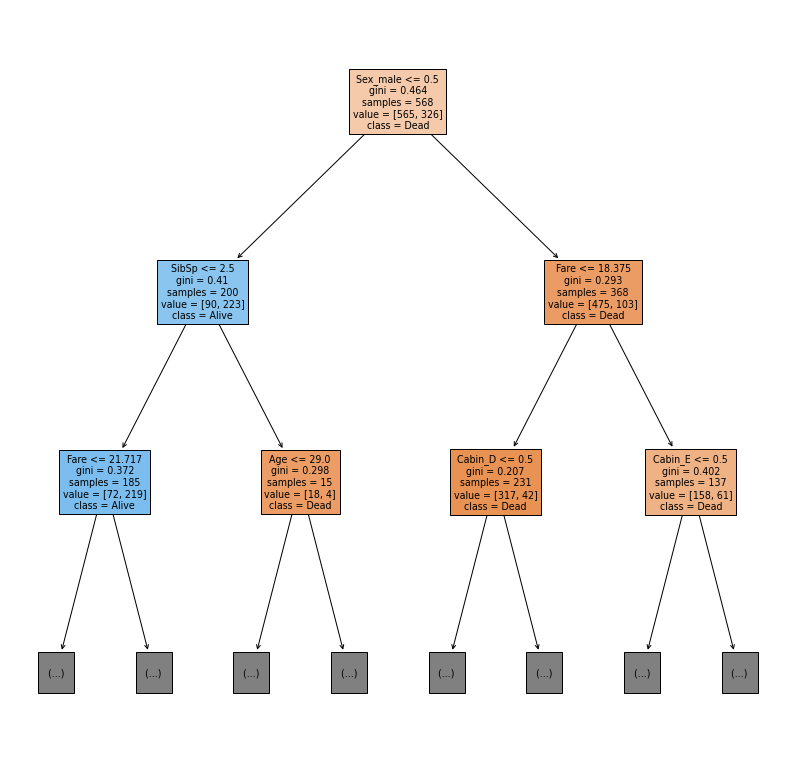

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
dt = clf.estimators_[1]
plt.figure(figsize=(14, 14))
plot_tree(dt, 
     feature_names=datas.columns, 
     class_names=["Dead", "Alive"],
     max_depth=2, 
     filled=True)

In [ ]:
import seaborn as sns
sns.countplot(y=train_df["Sex"], hue=train_df["Survived"])

In [ ]:
c = pd.cut(train_df["Fare"], bins=10)
def beatuify(s):
  return str(s)[1:-1].replace(","," - ")
b = c.apply(beatuify)
plt.figure(figsize= (10, 10))
sns.countplot(x=b, hue=train_df["Survived"])
plt.xticks(rotation=20)
plt.legend(loc="upper right")
plt.title("Fare Plot")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
datas_scale = scaler.fit_transform(datas)
datas_scale = pd.DataFrame(datas_scale, columns=datas.columns)
datas_scale

In [ ]:
x_scale = datas_scale.iloc[:len(train_df)]
predict_scale = datas_scale.iloc[len(train_df):]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
clf = KNeighborsClassifier()
params = {
    "n_neighbors":range(5, 200),
}
grid = GridSearchCV(clf, params, cv=10, n_jobs=-1, scoring="neg_log_loss")
grid.fit(x_scale,y)
print(grid.best_score_)
print(grid.best_params_)

-0.4375600153125087
{'n_neighbors': 33}


In [ ]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(x_scale, y)
pre = clf.predict(predict_scale)
ans = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
ans.to_csv("knn.csv", encoding="utf-8", index=False)